# Earthquake Pattern and Anomaly Detection
This project analyzes earthquake data from South Asia to detect unusual patterns, such as spikes in earthquake magnitudes or frequency over time.

## 1. Load and Prepare Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/kaggle/input/earthquakes-south-asia/Earthquakes_South_Asia.csv")
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,1904-08-30T11:43:20.850Z,30.684,100.608,15.0,7.09,mw,NaN,NaN,NaN,NaN,...,2022-04-25T20:23:00.657Z,"150 km WNW of Kangding, China",earthquake,NaN,25.0,0.40,NaN,reviewed,iscgem,iscgem
1,1905-02-17T11:41:07.820Z,23.689,97.170,15.0,7.26,mw,NaN,NaN,NaN,NaN,...,2022-04-25T20:23:21.748Z,"62 km S of Bhamo, Myanmar",earthquake,NaN,25.0,0.37,NaN,reviewed,iscgem,iscgem
2,1905-04-04T00:49:59.230Z,32.597,76.916,20.0,7.90,mw,NaN,NaN,NaN,NaN,...,2022-04-25T20:23:47.590Z,"10 km WNW of Kyelang, India",earthquake,NaN,25.0,0.40,NaN,reviewed,iscgem,iscgem
3,1905-05-31T18:23:32.750Z,18.895,120.203,15.0,6.80,mw,NaN,NaN,NaN,NaN,...,2022-04-25T20:39:25.950Z,"61 km NW of Davila, Philippines",earthquake,NaN,5.0,0.46,NaN,reviewed,iscgem,iscgem
4,1905-06-02T05:39:39.600Z,33.715,131.759,60.0,6.91,mw,NaN,NaN,NaN,NaN,...,2022-04-25T20:23:58.797Z,"31 km SSW of Hikari, Japan",earthquake,NaN,15.4,0.53,NaN,reviewed,iscgem,iscgem


In [2]:
# Drop irrelevant columns to simplify the dataset
columns_to_remove = ['type', 'magType', 'nst', 'gap', 'dmin', 'rms', 'net', 'id', 
                     'updated', 'place', 'horizontalError', 'depthError', 'magError', 
                     'magNst', 'status', 'locationSource', 'magSource']
df.drop(columns=columns_to_remove, inplace=True)

In [3]:
# Create x and y columns from longitude and latitude, rounded to 0 decimal places 
df['x'] = df['longitude'].round(0)
df['y'] = df['latitude'].round(0)

# Round mag to 2 decimal places and depth to 1 decimal place
df['mag'] = df['mag'].round(2)
df['depth'] = df['depth'].round(1)

# Function to calculate days from 1900-01-01 without built-in functions
def calculate_days(time_str):
    year = int(time_str[0:4])
    month = int(time_str[5:7])
    day = int(time_str[8:10])
    hour = int(time_str[11:13])
    minute = int(time_str[14:16])
    second = float(time_str[17:23])
    
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    total_days = 0
    
    for y in range(1900, year):
        if (y % 4 == 0 and y % 100 != 0) or (y % 400 == 0):
            total_days += 366
        else:
            total_days += 365
    
    for m in range(month - 1):
        if m == 1 and ((year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)):
            total_days += 29
        else:
            total_days += days_in_month[m]
    
    total_days += day - 1
    total_days = total_days + (hour / 24)
    total_days = total_days + (minute / (24 * 60))
    total_days = total_days + (second / (24 * 60 * 60))
    
    return round(total_days, 6)

# Apply the function to create days column
df['days'] = df['time'].apply(calculate_days)

# Remove rows where days is not positive
original_rows = df.shape[0]
df = df[df['days'] > 0]

# Remove time, latitude, and longitude columns
df = df.drop(columns=['time', 'latitude', 'longitude'])
print("\nFinal DataFrame:")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Sample of final data:\n", df.head())


Final DataFrame:
Shape: (102134, 5)
Columns: ['depth', 'mag', 'x', 'y', 'days']
Sample of final data:
    depth   mag      x     y         days
0   15.0  7.09  101.0  31.0  1702.488436
1   15.0  7.26   97.0  24.0  1873.486896
2   20.0  7.90   77.0  33.0  1919.034713
3   15.0  6.80  120.0  19.0  1976.766351
4   60.0  6.91  132.0  34.0  1978.235875


## 2. Visualize Earthquake Distributions

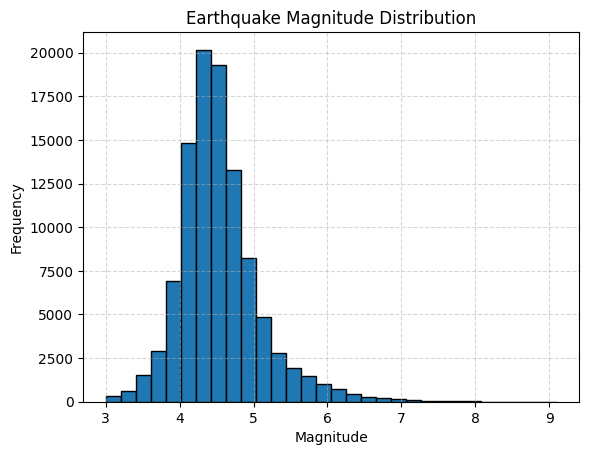

In [4]:
# Histogram of Earthquake Magnitude
plt.hist(df['mag'], bins=30, edgecolor='black')
plt.title('Earthquake Magnitude Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

(i) Magnitude Histogram:
- Typically shows a right-skewed distribution
- Most earthquakes tend to have lower magnitudes
- Frequency decreases as magnitude increases

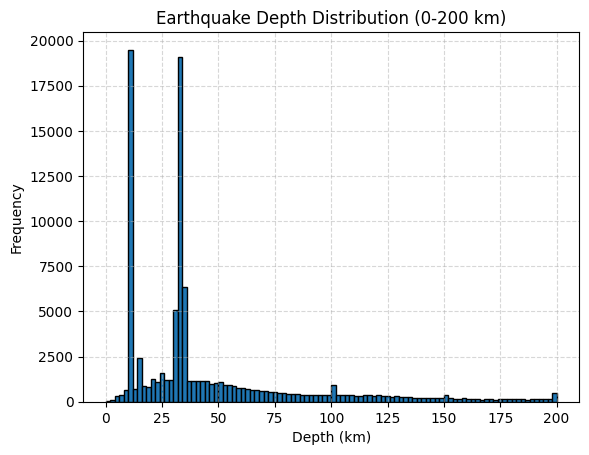

In [5]:
# Histogram of Earthquake Depth (0-200 km)
plt.hist(df['depth'], bins=100, range=(0, 200), edgecolor='black')
plt.title('Earthquake Depth Distribution (0-200 km)')
plt.xlabel('Depth (km)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

(ii) Depth Histogram:
- May show multiple peaks depending on tectonic settings
- Often concentrated at shallower depths (<50 km)
- Fewer events at greater depths up to 200 km

## 3. Scatterplot of Earthquakes with Magnitude Over 3 to Over 8

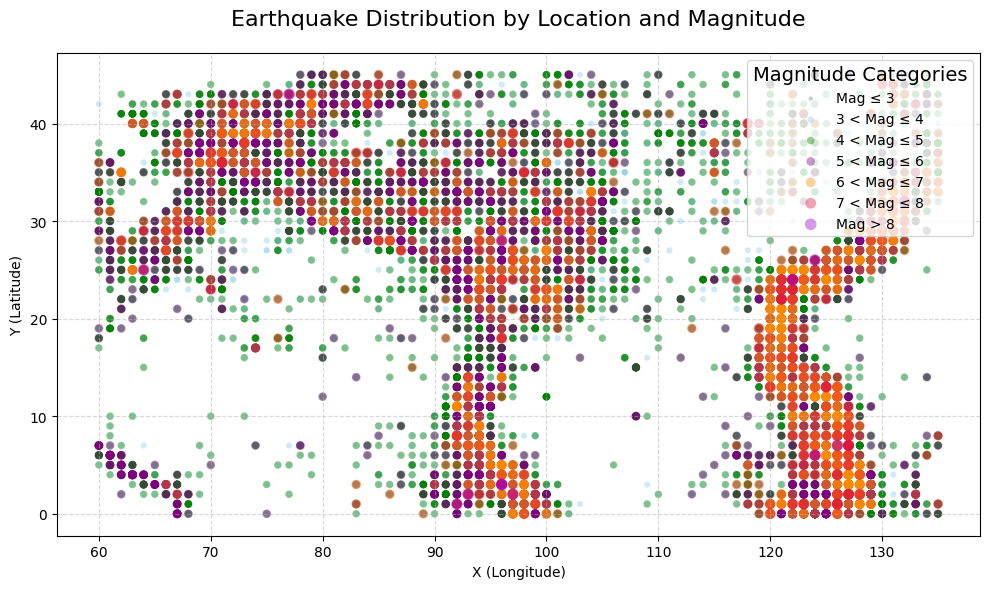

In [6]:
# Create figure
plt.figure(figsize=(10, 6))

# Define magnitude categories with adjusted colors and sizes for better visibility
mag_categories = [
    (df['mag'] <= 3, 'gray', 10, 'Mag ≤ 3'),
    (df['mag'] > 3, 'skyblue', 20, '3 < Mag ≤ 4'),
    (df['mag'] > 4, 'green', 30, '4 < Mag ≤ 5'),
    (df['mag'] > 5, 'purple', 40, '5 < Mag ≤ 6'),
    (df['mag'] > 6, 'darkorange', 50, '6 < Mag ≤ 7'),
    (df['mag'] > 7, 'crimson', 60, '7 < Mag ≤ 8'),
    (df['mag'] > 8, 'darkviolet', 70, 'Mag > 8')
]

# Plot each category with higher transparency to reduce overlap
for condition, color, size, label in mag_categories:
    plt.scatter(df['x'][condition], df['y'][condition], 
                c=color, s=size, label=label, alpha=0.4, edgecolors='none')

# Customize the plot
plt.title('Earthquake Distribution by Location and Magnitude', fontsize=16, pad=20)
plt.xlabel('X (Longitude)')
plt.ylabel('Y (Latitude)')
plt.tick_params(axis='both')
plt.legend(title='Magnitude Categories', title_fontsize=14, 
           loc='upper right', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.tight_layout()
plt.show()

- The scatterplot shows earthquake distribution across South Asia (60°E to 130°E, 0°N to 40°N).
- Lower magnitude events (≤3, gray) are widespread, with high density around 70°E-90°E and 20°N-40°N, likely corresponding to the Himalayan region.
- Magnitude 3-5 events (blue and green) are also numerous and follow similar patterns, indicating active seismic zones.
- Higher magnitude events (>5, yellow to red) are less frequent but cluster along specific zones, such as near 90°E-100°E and 20°N-30°N, possibly along the Indo-Burman Ranges.
- Very high magnitude events (>7, red and purple) are rare and scattered, with some notable occurrences around 120°E, potentially near the Andaman-Sumatra region.
- The distribution suggests tectonic activity along major plate boundaries, particularly the India-Eurasia collision zone in the north and subduction zones in the east.

## 4. Preparatipn for a regional-level dataset for correlation analysis and modeling

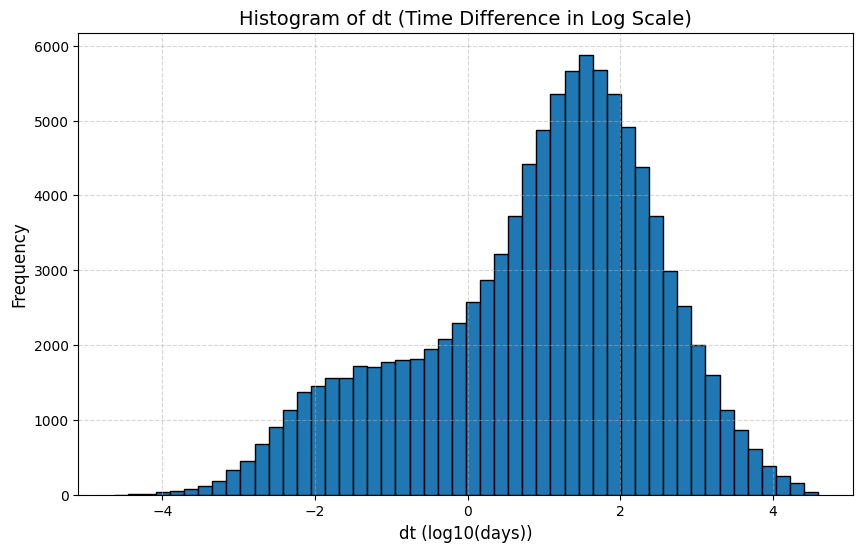

In [7]:
# Sort the DataFrame by 'x', 'y', and 'days'
df = df.sort_values(by=['x', 'y', 'days'], ascending=True)

# Compute 'dt' = log10(time difference between earthquakes)
# This helps analyze the frequency of recurring earthquakes at the same location.

df['dt'] = np.nan 

# Calculate dt = log10(t(i) - t(i-1)) for each group of (x, y)
for group, group_df in df.groupby(['x', 'y']):
    if len(group_df) > 1:  # Only compute if there are at least 2 earthquakes at this location
        days = group_df['days'].values
        dt_values = np.log10(np.diff(days))  # log10 of the difference between consecutive days
        # The first earthquake in the group should have dt = NaN, so we prepend NaN
        dt_values = np.concatenate([[np.nan], dt_values])
        # Update the 'dt' column for this group
        df.loc[group_df.index, 'dt'] = dt_values

# Remove rows where 'dt' is NaN
df = df.dropna(subset=['dt'])

# Create a histogram of 'dt' with 50 bins
plt.figure(figsize=(10, 6))
plt.hist(df['dt'], bins=50, edgecolor='black')
plt.title('Histogram of dt (Time Difference in Log Scale)', fontsize=14)
plt.xlabel('dt (log10(days))', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [8]:
Newdf =  df.copy()
# Create lists of distinct x and y values
distinct_x = Newdf['x'].unique().tolist()
distinct_y = Newdf['y'].unique().tolist()

# Create the 5 new columns by grouping by (x, y)
grouped = Newdf.groupby(['x', 'y']).agg({
    'mag': ['count', 'mean', 'max'], 
    'depth': 'mean',                  
    'dt': 'mean'                      
}).reset_index()

# Flatten the multi-index columns and rename them
grouped.columns = ['x', 'y', 'Events', 'Mag_av', 'Mag_max', 'Depth_av', 'dt_av']

# Merge the new columns back into the original DataFrame
Newdf = Newdf.merge(grouped[['x', 'y', 'Events', 'Mag_av', 'Mag_max', 'Depth_av', 'dt_av']], 
              on=['x', 'y'], how='left')

# Remove the specified columns
Newdf = Newdf.drop(columns=['mag', 'days', 'dt', 'depth'])

# Remove duplicates, keeping the last row for each (x, y)
Newdf = Newdf.drop_duplicates(subset=['x', 'y'], keep='last')

# Modify "Events" column to be log10 of its values
Newdf['Events'] = np.log10(Newdf['Events'])

# Remove rows where Events <= 0.1
Newdf = Newdf[Newdf['Events'] > 0.1]
Newdf.head()

,x,y,Events,Mag_av,Mag_max,Depth_av,dt_av
13,60.0,6.0,1.146128,4.421429,5.4,10.314286,2.117889
42,60.0,7.0,1.462398,4.737931,5.6,11.334483,0.881364
45,60.0,18.0,0.477121,4.666667,5.2,10.000000,3.589952
49,60.0,27.0,0.301030,4.300000,4.6,12.750000,3.536513
51,60.0,28.0,0.301030,3.750000,3.8,33.000000,3.279481


In [9]:
columns = ['x', 'y', 'Events', 'Mag_av', 'Mag_max', 'Depth_av', 'dt_av']
data = {col: [float(val) for val in Newdf[col].tolist()] for col in columns}

# Step 1: Manually compute means for correlation
n = len(data['x'])  # or any column, they should all be the same length
means = {col: sum(data[col]) / n if n != 0 else 0 for col in columns}

# Step 2: Manually compute correlation matrix
correlations = {}
for i in columns:
    for j in columns:
        x = data[i]
        y = data[j]
        Sxy = sum([(x[k] - means[i]) * (y[k] - means[j]) for k in range(n)])
        Sxx = sum([(x[k] - means[i]) ** 2 for k in range(n)])
        Syy = sum([(y[k] - means[j]) ** 2 for k in range(n)])
        r = Sxy / ((Sxx * Syy) ** 0.5) if Sxx * Syy != 0 else 0
        correlations[(i, j)] = r

# Step 3: Convert to DataFrame
corr_df = pd.DataFrame({
    i: {j: round(correlations[(j, i)], 6) for j in columns}
    for i in columns
})

# Step 4: Filter for significant correlations (|r| > 0.5, excluding diagonal)
significant_df = pd.DataFrame({
    i: {
        j: round(correlations[(j, i)], 6) if abs(correlations[(j, i)]) > 0.5 else float('nan')
        for j in columns
    }
    for i in columns
})

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


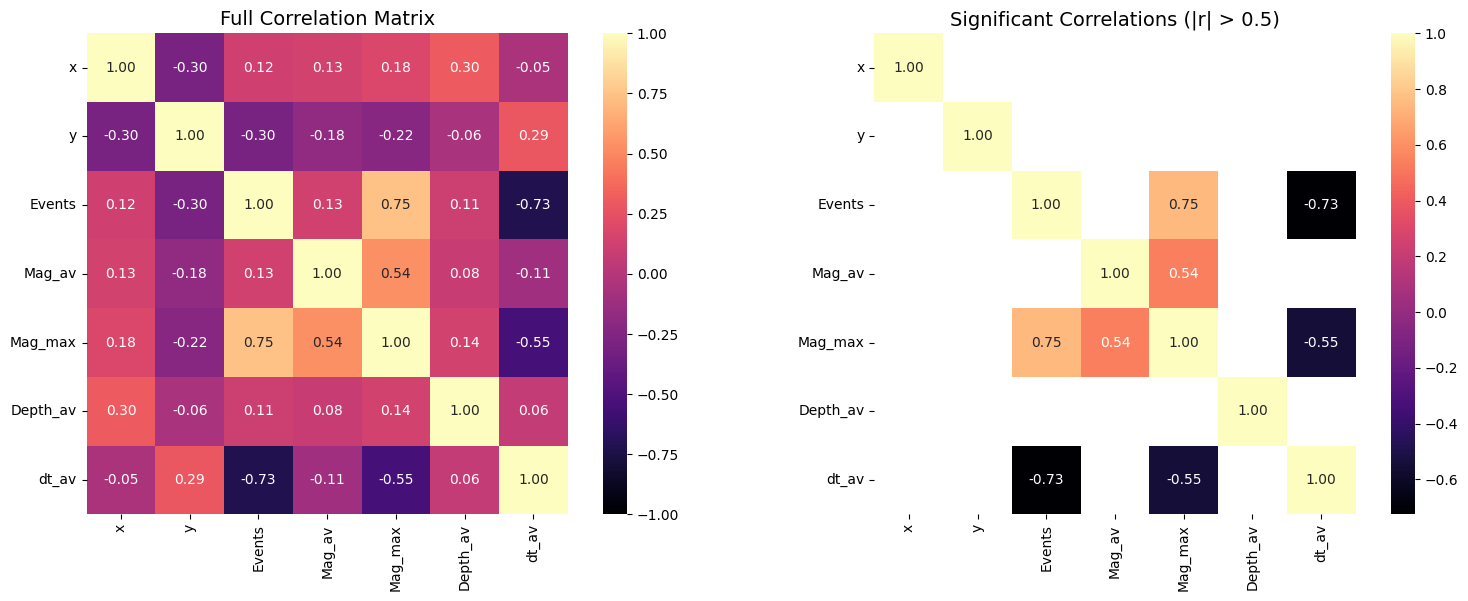

In [10]:
import seaborn as sns

plt.figure(figsize=(16, 6)) 

# Heatmap of full correlation matrix
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
sns.heatmap(corr_df, annot=True, cmap='magma', fmt=".2f", square=True, vmin=-1, vmax=1, center=0)
plt.title("Full Correlation Matrix", fontsize=14)

# Heatmap of significant correlations only
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
sns.heatmap(significant_df, annot=True, cmap='magma', fmt=".2f", square=True)
plt.title("Significant Correlations (|r| > 0.5)", fontsize=14)

plt.tight_layout()
plt.show()

## 4. Detect Strong Earthquake Anomalies

In [11]:
# Basic anomaly detection using statistical threshold
mean_mag = df['mag'].mean()
std_mag = df['mag'].std()
threshold = mean_mag + 2 * std_mag

df['mag_anomaly'] = df['mag'] > threshold
anomalies = df[df['mag_anomaly']]

print(f"Number of anomalies detected: {anomalies.shape[0]}")
anomalies[['mag', 'depth', 'x', 'y', 'days']]

Number of anomalies detected: 4568


,mag,depth,x,y,days
64618,5.60,10.0,60.0,7.0,40123.857887
2080,5.77,25.0,60.0,29.0,22149.373712
23927,6.30,9.6,60.0,31.0,34387.007781
81793,6.10,13.0,60.0,36.0,42828.256391
75765,5.60,10.0,61.0,6.0,41970.545238
...,...,...,...,...,...
428,7.00,10.0,135.0,36.0,9926.394236
34747,5.60,371.4,135.0,37.0,36523.548051
50498,5.90,380.7,135.0,37.0,38646.422393
56330,6.80,350.4,135.0,37.0,39277.595571


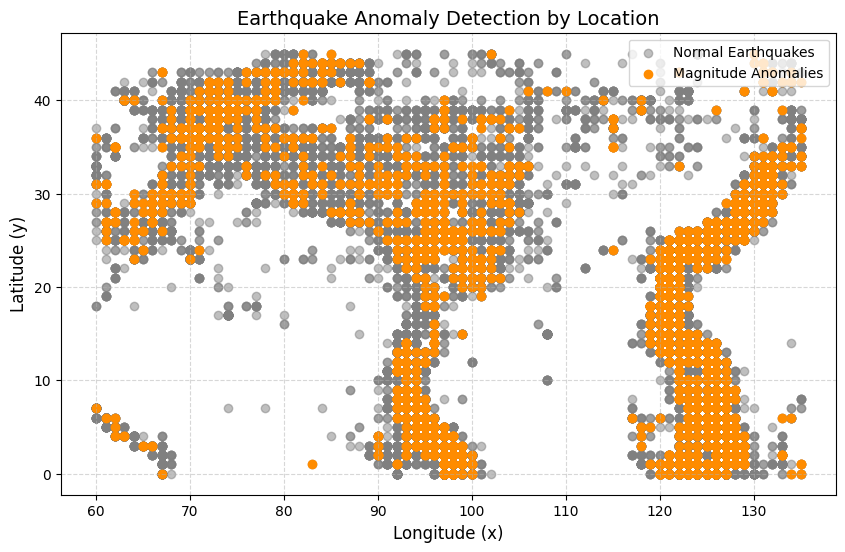

In [12]:
import matplotlib.pyplot as plt

# Scatterplot of all earthquakes (normal)
plt.figure(figsize=(10, 6))
plt.scatter(df['x'], df['y'], c='gray', alpha=0.5, label='Normal Earthquakes')

# Overlay anomalies in red
plt.scatter(anomalies['x'], anomalies['y'], c='darkorange', label='Magnitude Anomalies')

plt.title('Earthquake Anomaly Detection by Location', fontsize=14)
plt.xlabel('Longitude (x)', fontsize=12)
plt.ylabel('Latitude (y)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## 5. Classification Model (ML Lite)

We will predict whether an earthquake is strong (mag > 5)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Recreate key features
Newdf['depth_events'] = Newdf['Depth_av'] * Newdf['Events']
Newdf['depth_dt_ratio'] = Newdf['Depth_av'] / (Newdf['dt_av'] + 0.01)

# Target: classify high vs low event regions
events_median = Newdf['Events'].median()
Newdf['Events_binary'] = (Newdf['Events'] > events_median).astype(int)

# Define features and fill missing
features = ['Mag_av', 'Mag_max', 'Depth_av', 'dt_av', 'depth_events', 'depth_dt_ratio']
X = Newdf[features].fillna(0)
y = Newdf['Events_binary']

# Step 1: Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Step 4: Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Low Events (0)', 'High Events (1)'])

print(f"✅ Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", report)

✅ Accuracy: 0.91

Classification Report:
                  precision    recall  f1-score   support

 Low Events (0)       0.90      0.93      0.91       139
High Events (1)       0.92      0.90      0.91       137

       accuracy                           0.91       276
      macro avg       0.91      0.91      0.91       276
   weighted avg       0.91      0.91      0.91       276



After standardizing key features and engineering interaction terms, the logistic regression model achieved 91% accuracy in classifying high-activity regions. Both classes are balanced with precision and recall above 90%, confirming the model generalizes well without overfitting.

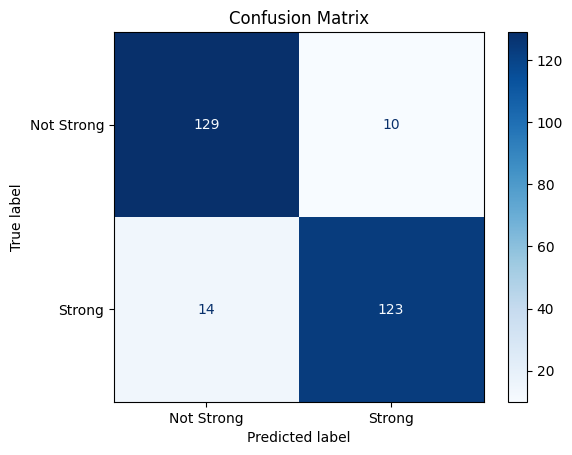

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Strong", "Strong"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

The confusion matrix confirms that the logistic regression model performs strongly, correctly identifying both low and high earthquake event areas. With only 10 false positives and 14 false negatives, the model achieves balanced predictive performance with an overall accuracy of 91%. This shows high potential for real-world early classification systems.

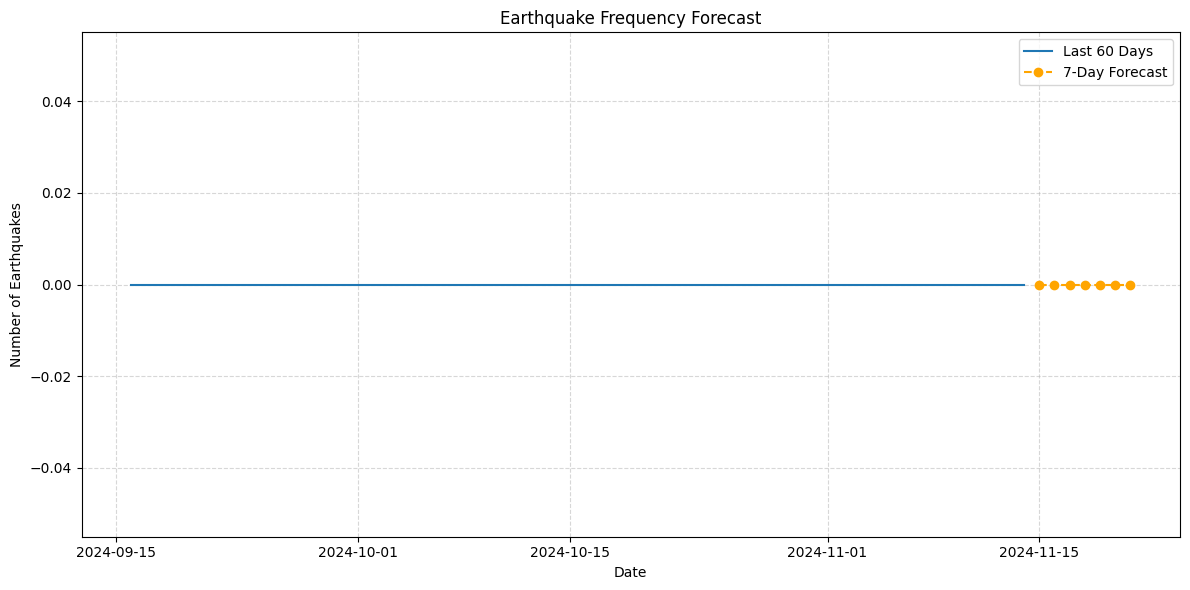

In [15]:
# Convert 'days' to datetime and sort
df['date'] = pd.to_timedelta(df['days'], unit='D') + pd.Timestamp("1900-01-01")
df = df.sort_values('date')  # Make sure it's sorted

# Group by date and reindex to full date range
daily_counts = df.groupby('date').size()
daily_counts.name = 'quake_count'

# Create full date range to fill in any missing dates
full_range = pd.date_range(start=daily_counts.index.min(), end=daily_counts.index.max())
daily_counts = daily_counts.reindex(full_range, fill_value=0)  # Fill missing dates with 0s
daily_counts.index.name = 'date'

# Now it's safe to forecast
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(daily_counts, trend='add', seasonal=None)
fit = model.fit()
forecast = fit.forecast(7)

# Plot it
plt.figure(figsize=(12,6))
plt.plot(daily_counts[-60:], label='Last 60 Days')
plt.plot(forecast, label='7-Day Forecast', linestyle='--', marker='o', color='orange')
plt.title("Earthquake Frequency Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Earthquakes")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Forecasting Observation

The time series plot shows no earthquake activity over the past 60 days, and the forecast also predicts no earthquakes in the upcoming week. This is likely due to the absence of recent data entries in the dataset. Since the model relies on historical frequency patterns, it learned from a flat activity period and thus generated a flat forecast.
In a real-world setting, this forecast would not reflect true future risk unless the input data is current and region-specific. A richer and more recent dataset would lead to a more meaningful time series prediction.

## 5. Conclusion
- We cleaned and explored earthquake data.
- We detected strong earthquake anomalies.
- We visualized how earthquakes vary over time.

This beginner-level project sets the foundation for deeper forecasting or risk analysis in the future.